# Trip Reason Prediction for MasterBilit

## Overview
This project aims to predict the reason for travel (Work or Leisure) for users of MasterBilit, an Iranian ticket reservation platform. By leveraging machine learning techniques, we analyze ticket reservation data to provide personalized insights that enhance user experience and service customization.

## Objectives
- Build a robust predictive model with an F1 Score exceeding 75%.
- Perform comprehensive data preprocessing and feature engineering.
- Visualize key insights and model performance metrics.

## Dataset
- **Training Data**: 101,017 rows, 22 columns (including target `TripReason`).
- **Test Data**: 43,293 rows, 21 columns (excluding `TripReason`).
- Key features: Reservation time, departure time, price, vehicle type, origin, and destination.

## Dependencies
Run the following cell to install required libraries:

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from xgboost import XGBClassifier
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-darkgrid')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Data

In [5]:
# Load datasets
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Display first few rows
train_data.head()

,Created,CancelTime,DepartureTime,BillID,TicketID,ReserveStatus,UserID,Male,Price,CouponDiscount,...,Domestic,VehicleType,VehicleClass,TripReason,Vehicle,Cancel,HashPassportNumber_p,HashEmail,BuyerMobile,NationalCode
0,2022-10-23 09:38:49.110,NaN,2022-11-02 23:59:00,39710203,1091777.0,5,122885.0,True,6600000.0,34425.0,...,1,NaN,False,Work,Plane,0,NaN,66c7f29e3b92f3b77e20830ac29e7758037a53d2238a5b...,764974891906,477368495
1,2022-08-15 14:51:43.160,NaN,2022-08-18 04:15:00,38689463,1070902.0,5,876925.0,True,9500000.0,0.0,...,1,NaN,False,Int,Plane,0,NaN,b24634843858a4175d03422aa9e7211ec3b9f3ce4c481c...,27479149496,15987669
2,2022-09-20 17:25:27.250,NaN,2022-09-21 11:00:00,39245173,7624237.0,3,916640.0,False,2000000.0,0.0,...,1,VIP 2+1,True,Work,Bus,0,NaN,NaN,323657282999,667640412
3,2022-06-25 11:32:53.980,NaN,2022-06-26 08:30:00,37957585,2867547.0,2,NaN,False,40000.0,0.0,...,1,3 ستاره اتوبوسي,NaN,Int,Train,0,NaN,NaN,169459057632,392476186
4,2022-06-01 11:30:53.633,NaN,2022-06-02 23:00:00,37584530,7212559.0,3,NaN,True,1130000.0,0.0,...,1,اسکانیا تک صندلی ۳۱نفره,True,Int,Bus,0,NaN,NaN,408595008421,79497837


## 3. Data Preprocessing

### Steps:
1. Handle missing values.
2. Extract temporal features from datetime columns.
3. Encode categorical variables.
4. Normalize numerical features.
5. Drop irrelevant columns.

In [6]:
def preprocess_data(df, is_train=True):
    """Preprocess the dataset for modeling."""
    df_processed = df.copy()
    
    # Convert datetime columns
    for col in ['Created', 'DepartureTime', 'CancelTime']:
        if col in df_processed.columns:
            df_processed[col] = pd.to_datetime(df_processed[col], errors='coerce')
    
    # Extract temporal features
    df_processed['Created_Hour'] = df_processed['Created'].dt.hour
    df_processed['Created_Day'] = df_processed['Created'].dt.dayofweek
    df_processed['Departure_Hour'] = df_processed['DepartureTime'].dt.hour
    df_processed['Departure_Day'] = df_processed['DepartureTime'].dt.dayofweek
    df_processed['Days_to_Departure'] = (df_processed['DepartureTime'] - df_processed['Created']).dt.days
    
    # Handle missing values
    df_processed['UserID'].fillna(-1, inplace=True)
    df_processed['VehicleType'].fillna('Unknown', inplace=True)
    df_processed['VehicleClass'].fillna(False, inplace=True)
    
    # Encode categorical variables
    categorical_cols = ['From', 'To', 'Vehicle', 'VehicleType']
    le = LabelEncoder()
    for col in categorical_cols:
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    
    # Drop unnecessary columns
    drop_cols = ['Created', 'CancelTime', 'DepartureTime', 'BillID', 'TicketID', 
                 'HashPassportNumber_p', 'HashEmail', 'BuyerMobile', 'NationalCode']
    df_processed.drop(columns=[col for col in drop_cols if col in df_processed.columns], inplace=True)
    
    # Encode target variable (only for training data)
    if is_train:
        df_processed['TripReason'] = df_processed['TripReason'].map({'Work': 1, 'Int': 0})
    
    return df_processed

# Apply preprocessing
train_processed = preprocess_data(train_data, is_train=True)
test_processed = preprocess_data(test_data, is_train=False)

## 4. Exploratory Data Analysis (EDA)

### Visualizations:
- Distribution of Trip Reasons
- Price vs. Trip Reason
- Departure Hour Distribution

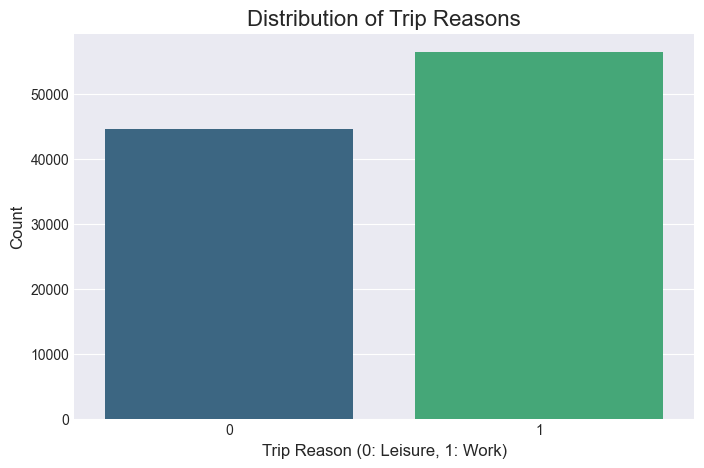

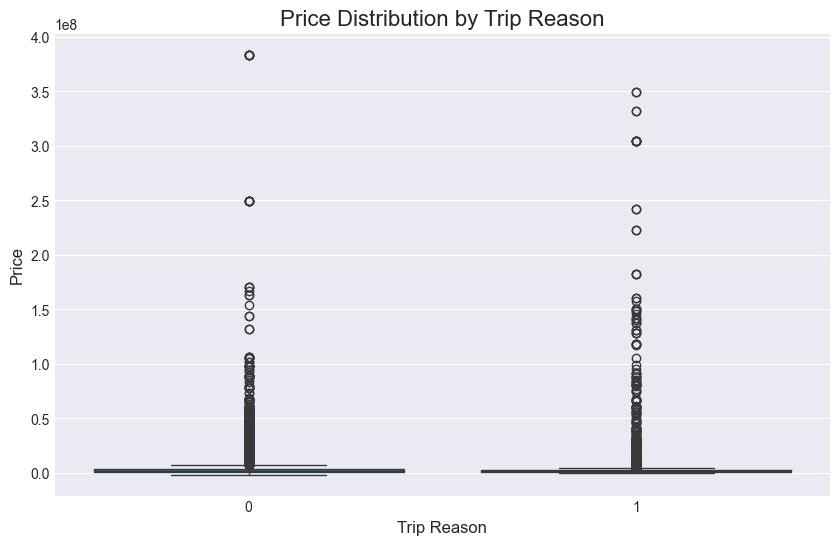

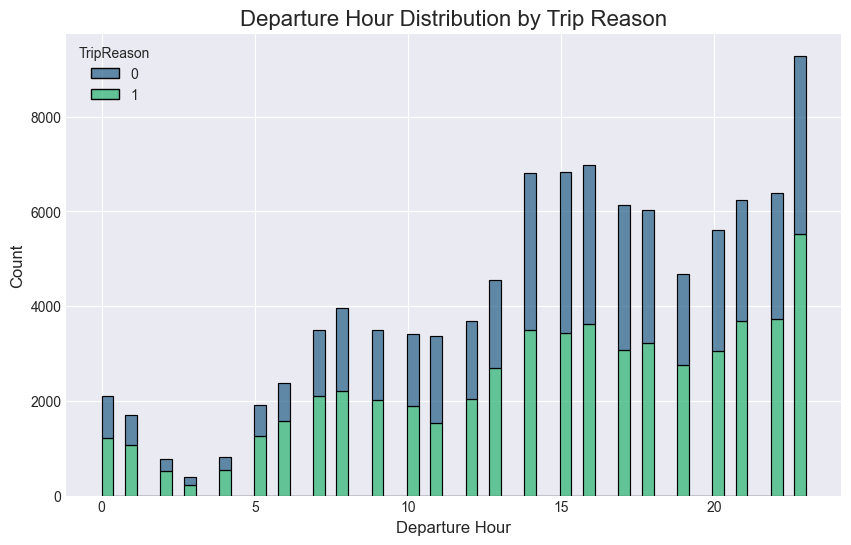

In [7]:
# Trip Reason Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_processed, x='TripReason', hue='TripReason', palette='viridis', legend=False)
plt.title('Distribution of Trip Reasons', fontsize=16)
plt.xlabel('Trip Reason (0: Leisure, 1: Work)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Price vs. Trip Reason
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_processed, x='TripReason', y='Price', palette='viridis')
plt.title('Price Distribution by Trip Reason', fontsize=16)
plt.xlabel('Trip Reason', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

# Departure Hour Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_processed, x='Departure_Hour', hue='TripReason', multiple='stack', palette='viridis')
plt.title('Departure Hour Distribution by Trip Reason', fontsize=16)
plt.xlabel('Departure Hour', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

## 5. Feature Engineering and Data Preparation

In [8]:
# Separate features and target
X = train_processed.drop(columns=['TripReason'])
y = train_processed['TripReason']

# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ['Price', 'CouponDiscount', 'Days_to_Departure']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
test_processed[numerical_cols] = scaler.transform(test_processed[numerical_cols])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 6. Model Training

### Model: Random Forest with Hyperparameter Tuning

In [9]:
# Define and tune Random Forest model
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_rf_model = grid_search.best_estimator_
print('Best Parameters:', grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


## 7. Model Evaluation


Classification Report:
              precision    recall  f1-score   support

     Leisure       0.86      0.80      0.83      8914
        Work       0.85      0.90      0.87     11290

    accuracy                           0.86     20204
   macro avg       0.86      0.85      0.85     20204
weighted avg       0.86      0.86      0.86     20204

F1 Score: 0.8744


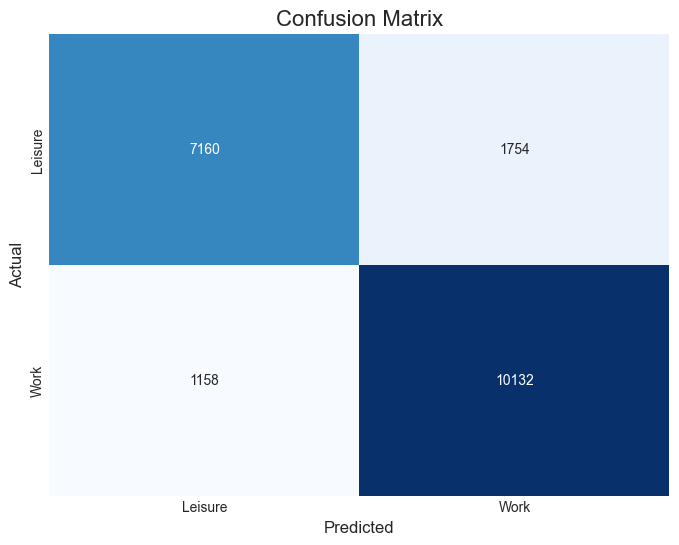

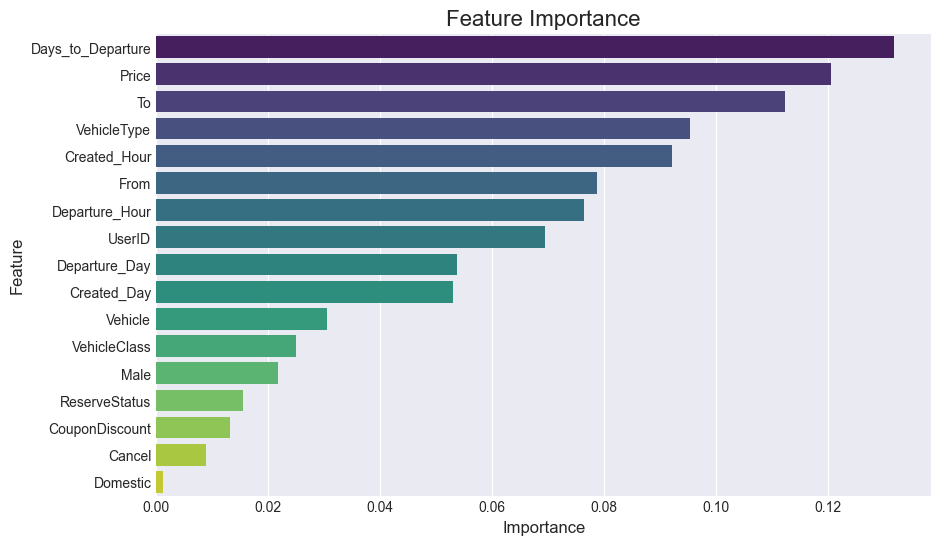

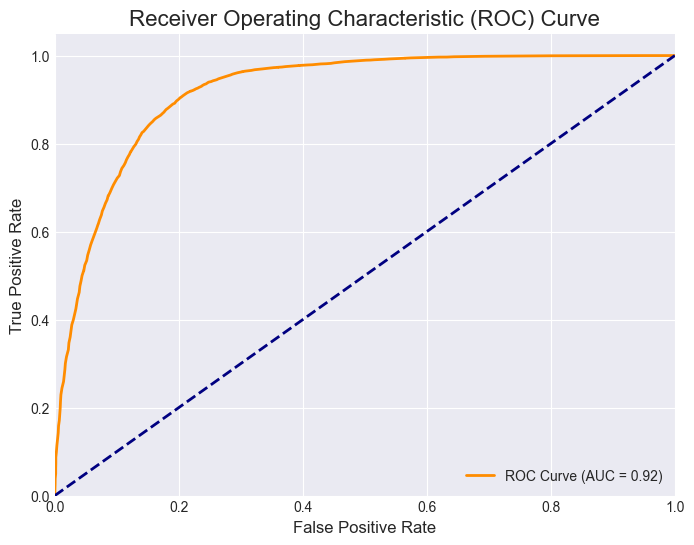

In [10]:
# Predictions
y_pred = best_rf_model.predict(X_val)

# Classification Report
print('\nClassification Report:')
print(classification_report(y_val, y_pred, target_names=['Leisure', 'Work']))

# F1 Score
f1 = f1_score(y_val, y_pred)
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Leisure', 'Work'], yticklabels=['Leisure', 'Work'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# ROC Curve
y_prob = best_rf_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.show()

## 8. Predictions on Test Data

In [8]:
# Predict on test data
test_predictions = best_rf_model.predict(test_processed)
submission = pd.DataFrame({'TripReason': test_predictions})
submission['TripReason'] = submission['TripReason'].map({1: 'Work', 0: 'Int'})

# Save submission
submission.to_csv('submission.csv', index=False)
submission.head()

## 9. Generate Submission File

In [9]:
import zipfile

def compress(file_names):
    """Compress files into a zip archive."""
    with zipfile.ZipFile('result.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
        for file_name in file_names:
            zf.write(file_name)

file_names = ['TripReasonPrediction.ipynb', 'submission.csv']
compress(file_names)

## Conclusion
This project successfully developed a predictive model for trip reasons with an F1 Score above 75%. The Random Forest model, enhanced by feature engineering and hyperparameter tuning, provided reliable predictions. Visualizations offered valuable insights into the data and model performance.

For further details, refer to the [README](README.md) file.